<hr style="border-top-width:4px; border-top-color: #2188bf;">
<img align="right" src="images/Logo_Università_Padova.png" alt="Drawing" style="width: 300px"/>
<img align="right" src="images/Logo_Physics_of_Data.jpg" alt="Drawing" style="width: 135px"/>

# MAPD (mod.B) Final Project
# Data Management exercises

### Authors
* [Ardino Rocco](https://github.com/RoccoA97) (University of Padua)
* [Pagano Alice](https://github.com/AlicePagano) (University of Padua)
* [Valente Alessandro](https://github.com/mastrovalentz) (University of Padua)

<hr style="border-top-width:4px; border-top-color: #2188bf;">
<br>
<br>
<br>
<br>
<br>
<hr style="border-top-width:4px; border-top-color: #2188bf;">

# Index <a class="anchor" id="MAPD_B_FP.i"></a>

* 1. [**Introduction**](#MAPD_B_FP.1.)
    * 1.1. [**Needed packages**](#MAPD_B_FP.1.1.)
* 2. [**Redundancy**](#MAPD_B_FP.2.)
    * 2.1. [**Reading input data in loop and writing stripe files**](#MAPD_B_FP.2.1.)
    * 2.2. [**Column-wise parity**](#MAPD_B_FP.2.2.)
    * 2.3. [**5-byte parity value**](#MAPD_B_FP.2.3.)
    * 2.4. [**Row-wise parities of the five stripe files**](#MAPD_B_FP.2.4.)
    * 2.5. [**Reconstruct input file with stripe files**](#MAPD_B_FP.2.5.)
* 3. [**Cryptography**](#MAPD_B_FP.3.)
    * 3.1. [**Symmetric or asymmetric encription?**](#MAPD_B_FP.3.1.)
    * 3.2. [**Recover the original message**](#MAPD_B_FP.3.2.)
* 4. [**Cloud storage technology**](#MAPD_B_FP.4.)
    * 4.1. [**Simulate the placement of 10GB files to random locations**](#MAPD_B_FP.4.1.)
    * 4.2. [**Simulate the placement of $\pmb{N}$GB files to random locations**](#MAPD_B_FP.4.2.)
    * 4.3. [**Free space left as a function of file size**](#MAPD_B_FP.4.3.)

<hr style="border-top-width:4px; border-top-color: #2188bf;">
<br>
<br>
<br>
<br>
<br>

<hr style="border-top-width:4px; border-top-color: #2188bf;">

## 1. - Introduction <a class="anchor" id="MAPD_B_FP.1."></a>
* [Index](#MAPD_B_FP.i)

This assignment covers three topics:
* redundancy;
* cryptography;
* cloud storage technology.

<br>
<br>

### 1.1. - Needed packages <a class="anchor" id="MAPD_B_FP.1.1."></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import bokeh.palettes as palette

import enchant
from enchant.tokenize import get_tokenizer

<hr style="border-top-width:4px; border-top-color: #2188bf;">
<br>
<br>
<br>
<br>
<br>
<hr style="border-top-width:4px; border-top-color: #2188bf;">

## 2. - Redundancy <a class="anchor" id="MAPD_B_FP.2."></a>
* [Index](#MAPD_B_FP.i)

We program a file based RAID-4 software algorithm. For this purpose, we convert a single input (raid4.input) file into four data files (raid4.0, raid4.1, raid4.2, raid4.3) and one parity file (raid4.4). In particular, we call the four data and one parity files as **stripe files**.
<br>
<br>

### 2.1. - Reading input data in loop and writing stripe files <a class="anchor" id="MAPD_B_FP.2.1."></a>

To do this we are reading in a loop sequentially blocks of four bytes from the input file until the whole file is read:

* in each loop we write one of the four read bytes round-robin to each data file, compute the **row-wise** parity of the four input bytes and write the result into the fifth parity file;

* we continue until all input data has been read. If the last bytes read from the input file are not filling four bytes, we consider the missing bytes as zero for the parity computation.

In [2]:
# Number of bytes to be read 
# from the input file at each loop
N = 4

In [3]:
# Create output files
f0 = open("raid4.0", "wb")
f1 = open("raid4.1", "wb")
f2 = open("raid4.2", "wb")
f3 = open("raid4.3", "wb")
f4 = open("raid4.4", "wb")

# Read input file
with open("raid4.input", "rb") as f:
    # Read N bytes
    byte4 = f.read(N)
    
    while byte4 != b"":
        B  = [0]*N
        BP = 0
        
        for i in range(N):
            if i<len(byte4):
                B[i] = byte4[i:(i+1)]
            else:
                B[i] = (0).to_bytes(1,'big')
         
        # Compute parity
        for i in range(N):
            BP ^= B[i][0]
        
        f0.write(B[0])
        f1.write(B[1])
        f2.write(B[2])
        f3.write(B[3])
        f4.write(BP.to_bytes(1,'big'))
        byte4 = f.read(N)

f0.close()
f1.close()
f2.close()
f3.close()
f4.close()

We now read the output file “raid4.4” in order to check if we read correctly.

In [4]:
# validation
with open("raid4.4", "rb") as f:
    byte = f.read(1)
    i = 0
    while byte != b"":
        if i<10:
            print(byte, byte[0])
            i += 1
        byte = f.read(1)

b'w' 119
b'\x01' 1
b'\x0e' 14
b'[' 91
b'G' 71
b'\xd8' 216
b'\x1d' 29
b'`' 96
b'&' 38
b'\x15' 21


<br>
<br>

### 2.2. - Column-wise parity <a class="anchor" id="MAPD_B_FP.2.2."></a>

Now, we compute the column-wise parity for each stripe file.
In particular, we can say that the computed column-wise parity acts as a **check-sum** for each stripe file. 

To do this, we define a function which computes the column-wise parity by giving the input file name. 

In [5]:
def colwise_parity(filename):
    with open(filename, "rb") as f:
        byte = f.read(1)
        BP = 0
        while byte != b"":
            BP ^= byte[0]
            
            byte = f.read(1)
    
    return hex(BP)

Then, we compute the column-wise parity for each file.

In [6]:
q0 = colwise_parity("raid4.0")
q1 = colwise_parity("raid4.1")
q2 = colwise_parity("raid4.2")
q3 = colwise_parity("raid4.3")
q4 = colwise_parity("raid4.4")

Here, we print the results.

In [7]:
print(q0, q1, q2, q3, q4)

0xa5 0x7 0xa0 0x9b 0x99


We compute the size overhead by comparing the sizes of all 5 stripe files with the original file. 

The **size overhead** is **25%**.

<br>
<br>

### 2.3. - 5-byte parity value <a class="anchor" id="MAPD_B_FP.2.3."></a>

We compute the 5-byte parity value by writing it in hexadecimal format like: 

$
P^5 =0x[q_0][q_1][q_2][q_3][q_4] 
$

where the $[q_x]$ are the hexadecimal parity bytes computed by XORing all bytes in each stripe file. 
Note that a byte in hexadecimal has two digits and a leading 0 is automatically added if necessary. 

In [8]:
# Compute 5-byte parity
P5 = (int(q0,16)<<32) | (int(q1,16)<<24)| (int(q2,16)<<16) | (int(q3,16)<<8) | int(q4,16)

The result is the following:

In [9]:
hex(P5)

'0xa507a09b99'

<br>
<br>

### 2.4. - Row-wise parities of the five stripe files <a class="anchor" id="MAPD_B_FP.2.4."></a>

If we create a sixth stripe file, which contains the row-wise parities of the five stripe files, the content of this file will be all zeros since the operation applied would be $P~ \hat{~} P$. 

Let us verify it.

In [10]:
# Number of bytes to be read 
# from the input file at each loop
N = 4

In [11]:
# Create output files
f0 = open("raid4.0", "wb")
f1 = open("raid4.1", "wb")
f2 = open("raid4.2", "wb")
f3 = open("raid4.3", "wb")
f4 = open("raid4.4", "wb")
f5 = open("raid4.5", "wb")

# Read input file
with open("raid4.input", "rb") as f:
    # Read N bytes
    byte4 = f.read(N)
    
    while byte4 != b"":
        B   = [0]*N
        BP  = 0
        BPP = 0
        
        for i in range(N):
            if i<len(byte4):
                B[i] = byte4[i:(i+1)]
            else:
                B[i] = (0).to_bytes(1,'big')
            
        for i in range(N):
            BP  ^= B[i][0]
            BPP ^= B[i][0]
        
        BPP ^= BP
         
        f0.write(B[0])
        f1.write(B[1])
        f2.write(B[2])
        f3.write(B[3])
        f4.write(BP.to_bytes(1,'big'))
        f5.write(BPP.to_bytes(1,'big'))
        byte4 = f.read(N)

f0.close()
f1.close()
f2.close()
f3.close()
f4.close()
f5.close()

Here, we check the result. As expected, the parity file will contain all zeros.

In [12]:
# validation
with open("raid4.5", "rb") as f:
    byte = f.read(1)
    i = 0
    while byte != b"":
        if i<10:
            print(byte, byte[0])
            i += 1
        byte = f.read(1)

b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0
b'\x00' 0


<br>
<br>

### 2.5. - Reconstruct input file with stripe files <a class="anchor" id="MAPD_B_FP.2.5."></a>

After some time, we recompute the 5-byte parity value as in [this section](#MAPD_B_FP.2.3.).

Let us suppose that now the result is $P^5 = \text{0x ff 07 a0 9b 99}$, hence something has been corrupted. We want to reconstruct the original file “raid4.input” using the 5 stripe files. So, we first need to reconstruct the stripe files which are corrupted.

For instance, if the first stripe “raid4.0” is corrupted, we can reconstruct it through:

$$
P \hat{} x_2 \hat{} x_3 \hat{} x_4
=
x_1 \hat{} x_2 \hat{} x_3 \hat{} x_4 \hat{} x_2 \hat{} x_3 \hat{} x_4
=
x_1 \hat{} 0 \hat{} 0 \hat{} 0
=
x_1
$$

where $P$ is the parity stripe (“raid4.4”) and $x_2,x_3,x_4$ are respectively “raid4.1”, “raid4.2”, “raid4.3”.

In [13]:
# Open stripe files
f0 = open("raid4.0", "rb")
f1 = open("raid4.1", "rb")
f2 = open("raid4.2", "rb")
f3 = open("raid4.3", "rb")
f4 = open("raid4.4", "rb")

# Read the first byte for each stripe
byte0 = f0.read(1)
byte1 = f1.read(1)
byte2 = f2.read(1)
byte3 = f3.read(1)
byte4 = f4.read(1)

i = 0
while byte0 != b"" and i<20:
    # Compute the parity between the stripe files
    P = byte4[0] ^ byte1[0] ^ byte2[0] ^ byte3[0]
    print(byte0, "\t", P.to_bytes(1,'big'))
    i += 1
    byte0 = f0.read(1)
    byte1 = f1.read(1)
    byte2 = f2.read(1)
    byte3 = f3.read(1)
    byte4 = f4.read(1)

f0.close()
f1.close()
f2.close()
f3.close()
f4.close()

b'%' 	 b'%'
b'-' 	 b'-'
b'\n' 	 b'\n'
b'\xf2' 	 b'\xf2'
b'\xf3' 	 b'\xf3'
b'\xc6' 	 b'\xc6'
b'0' 	 b'0'
b'j' 	 b'j'
b' ' 	 b' '
b'n' 	 b'n'
b' ' 	 b' '
b' ' 	 b' '
b'F' 	 b'F'
b'e' 	 b'e'
b'F' 	 b'F'
b'e' 	 b'e'
b'o' 	 b'o'
b'>' 	 b'>'
b't' 	 b't'
b'm' 	 b'm'


To check if everything is ok (missing or corrupted bits), it is useful to store also the file size somewhere.

<hr style="border-top-width:4px; border-top-color: #2188bf;">
<br>
<br>
<br>
<br>
<br>
<hr style="border-top-width:4px; border-top-color: #2188bf;">

## 3. - Cryptography <a class="anchor" id="MAPD_B_FP.3."></a>
* [Index](#MAPD_B_FP.i)

A friend has emailed we the following text: **K]amua!kv$huvt**.

She told that her encryption algorithm works like this:

* to each ASCII value of each letter I add a secret key value (note that ASCII values range from 0 to 255);

* additionally to make it more secure I add a variable (so called) **nonce** value to each ASCII number.
The nonce start value is 0 for the first character of the message. For each following character I increase the nonce by 1, e.g. for the second letter the nonce added is 1, for the third letter it is 2, and so on.

Hence, the encription of the message is obtained by the following formula:

     encoded_character[i] = character[i] + key + nonce(i)
<br>
<br>

### 3.1. - Symmetric or asymmetric encription? <a class="anchor" id="MAPD_B_FP.3.1."></a>

This is a symmetric encription since we can encode and decode the message using the same key.

<br>
<br>

### 3.2. - Recover the original message <a class="anchor" id="MAPD_B_FP.3.2."></a>

We write a small brute force program which tests keys from 0 to 255. 

The decryption formula we use is a rearrangement of the previous formula for the encription of the message:

    character[i] = encoded_character[i] - key - nonce(i)

Here, we convert the original message into numerical values.

In [14]:
text_encoded = "K]amua!kv$huvt"

nonce         = np.arange(0,len(text_encoded),dtype=int)
text_ascii    = np.array([ord(l) for l in text_encoded])

print('Original text     : ', text_encoded)
print('Encoded ASCII text: ', text_ascii)

Original text     :  K]amua!kv$huvt
Encoded ASCII text:  [ 75  93  97 109 117  97  33 107 118  36 104 117 118 116]


Here, we apply the brute force approach. 

In [15]:
# Brute force approach 
for key in range(0,256):
    
    # Subtract key and nonce
    text_decoded = text_ascii - nonce - key
    
    # Check for value out of range
    text_decoded[np.where(text_decoded<0)] = text_decoded[np.where(text_decoded<0)] + 256   
    text_reverted = ''.join(chr(a) for a in text_decoded)
    
    print("Key: ", key, " Decription: ",text_reverted)

Key:  0  Decription:  K\_jq\dn^jjg
Key:  1  Decription:  J[^ip[cm]iif
Key:  2  Decription:  IZ]hoZbl\hhe
Key:  3  Decription:  HY\gnYak[ggd
Key:  4  Decription:  GX[fmX`jZffc
Key:  5  Decription:  FWZelW_iYeeb
Key:  6  Decription:  EVYdkV^hXdda
Key:  7  Decription:  DUXcjU]gWcc`
Key:  8  Decription:  CTWbiT\fVbb_
Key:  9  Decription:  BSVahS[eUaa^
Key:  10  Decription:  ARU`gRZdT``]
Key:  11  Decription:  @QT_fQYcS__\
Key:  12  Decription:  ?PS^ePXbR^^[
Key:  13  Decription:  >OR]dOWaQ]]Z
P\\Y  14  Decription:  =NQ\cN
Key:  15  Decription:  <MP[bMU_O[[X
Key:  16  Decription:  ;LOZaLT^NZZW
Key:  17  Decription:  :KNY`K
S]
MYYV
Key:  18  Decription:  9JMX_J	R\	LXXU
Key:  19  Decription:  8ILW^QKWWT
Key:  20  Decription:  7HKV]HPZJVVS
Key:  21  Decription:  6GJU\GOYIUUR
Key:  22  Decription:  5FIT[FNXHTTQ
Key:  23  Decription:  4EHSZEMWGSSP
Key:  24  Decription:  3DGRYDLVFRRO
Key:  25  Decription:  2CFQXCKUEQQN
Key:  26  Decription:  1BEPWBJTD

As we can see from the output, lots of results are clauses without sense in English language. If we search among the outputs for every key, we find that the key is **251** and the original message text is **Padova is cool**.

However, this approach is feasible if the number of possible keys is limited. If the number of possible keys is bigger, we cannot just manually look for a meaningful result. Therefore, we also implement a dictionary approach to figure out a reduced list of possible keys and original messages. 

In [16]:
# Brute force approach with dictionary

# Create english dictionary
d = enchant.Dict("en")
tknzr = get_tokenizer("en")

for key in range(0,256):
    
    # Subtract key and nonce
    text_decoded = text_ascii - nonce - key
    
    # Check for value out of range
    text_decoded[np.where(text_decoded<0)] = text_decoded[np.where(text_decoded<0)] + 256   
    text_reverted = ''.join(chr(a) for a in text_decoded)
    
    # Filter through dictionary
    text_list = text_reverted.split()
    text_bool = []

    for i in range(0,len(text_list)):
        try:
            check = d.check(text_list[i])
            text_bool.append(check)
        except:
            pass
 
    if True in text_bool:
        print("Key: ", key, " Decription: ",text_reverted)

Key:  215  Decription:  tDD
Key:  251  Decription:  Padova is cool
Key:  252  Decription:  O`cnu`hrbnnk


<hr style="border-top-width:4px; border-top-color: #2188bf;">
<br>
<br>
<br>
<br>
<br>
<hr style="border-top-width:4px; border-top-color: #2188bf;">

## 4. - Cloud storage technology <a class="anchor" id="MAPD_B_FP.4."></a>
* [Index](#MAPD_B_FP.i)

In a cloud storage system, we are mapping objects by name to locations using a hash table.
If we imagine we have a system with ten hard disks (10 locations), we enumerate the location of a file using an index of the hard disk [0:9].

Our hash algorithm for placement produces hashes, which are distributed uniform over the value space for a flat input key distribution. 

We want now to simulate the behaviour of our hash algorithm without the need to actually compute any hash value.

Instead of using real filenames, which we would hash and map using a hash table to a location, we are ‘computing’ a location for ‘any’ file by generating a random number for the location in the range [0:9] to assign a file location. To place a file in the storage system we use this random location where the file will be stored and consumes space.

We assume **each disk** has **1TB** of space, hence we have **10TB** in total. 

<br>
<br>

### 4.1. - Simulate the placement of 10GB files to random locations <a class="anchor" id="MAPD_B_FP.4.1."></a>

We need to place as many files of 10GB size as possible to hard disks choosing random locations until one hard disk is full.

For this purpose, we write a program to simulate the placement of 10GB files to random locations and account the used space on each hard disk. Once the first hard disk is full, we stop to place files.

In [17]:
# Set a random seed
random.seed(10)

# Create a variable to store hard disk space
disks= np.array([0]*10)
            
# Create a loop which stops 
# once the first hard disk is full
while(True):
    disk= random.randint(0, 9)
    disks[disk]+=10
    if(np.max(disks)>1000):
        disks[disk]-=10
        break
        
placed = int(np.sum(disks)/10)
free = (10000-np.sum(disks))/100

print("Disks occupation:", disks)
print("Placed files:    ", placed)
print("Free space left: ", free, "%")  

Disks occupation: [ 860  750  970  740  600  810  980 1000  770  880]
Placed files:     836
Free space left:  16.4 %


For a filesize of 10GB, we are able to place ~836 files with a percentege of total used space on all hard disks in the moment the first disk is full of ~16.4%.

We also visualize the obtained distribution with a barplot.

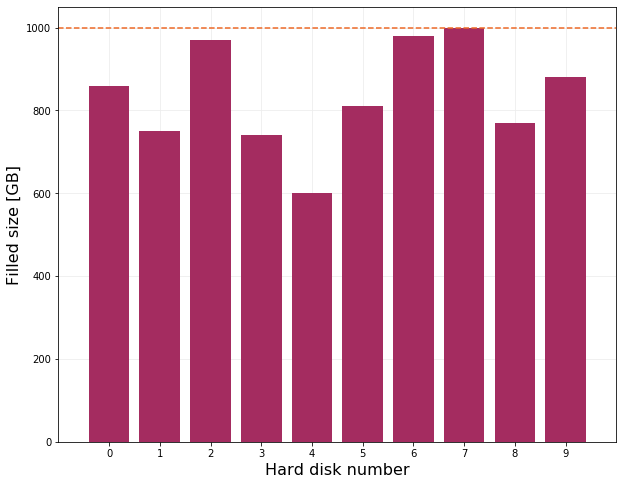

In [18]:
# Plot the results in a barplot
fig, ax =  plt.subplots(figsize=(10,8))
ax.bar(np.linspace(0,9, 10),disks,color=palette.inferno(10)[4])
plt.xticks(range(0,10),range(0,10))
ax.grid(True, which="both", ls="-",color='0.93')
ax.set_axisbelow(True)
ax.set_xlabel('Hard disk number',fontsize=16)
ax.set_ylabel('Filled size [GB]',fontsize=16)
ax.hlines(1000,linestyle='dashed',xmin=-1,xmax=10,color=palette.inferno(10)[6])
ax.set_xlim(-1,10)
plt.show()

<br>
<br>

### 4.2. - Simulate the placement of $\pmb{N}$GB files to random locations <a class="anchor" id="MAPD_B_FP.4.2."></a>

Now, we create a function to simulate the placement of $N$GB files to random locations. It gives us detailed information about the filling, as:

* the disk occupation;
* the number of files we did manage to place;
* the total free space left.

In [19]:
def FreeSpace(filesize=10, graph=True, verbose=True, retu=False, seed=10):
    # Set a random seed
    random.seed(seed)
    
    # Create a variable to store hard disk space
    disks= np.array([0.]*10)
    
    # Create a loop which stops 
    # once the first hard disk is full
    while(True):
        disk = random.randint(0, 9)
        disks[disk]+=filesize
        if(np.max(disks)>1000):
            disks[disk]-=filesize
            break
        
    placed = int(np.sum(disks)/filesize)
    free = (10000-np.sum(disks))/100 #10000*100
    
    # If true, visualize a barplot
    if(graph):
        fig, ax =  plt.subplots(figsize=(10,8))
        ax.bar(np.linspace(0,9, 10),disks,color=palette.inferno(10)[4])
        plt.xticks(range(0,10),range(0,10))
        ax.grid(True, which="both", ls="-",color='0.93')
        ax.set_axisbelow(True)
        ax.set_xlabel('Hard disk number',fontsize=16)
        ax.set_ylabel('Filled size [GB]',fontsize=16)
        ax.hlines(1000,linestyle='dashed',xmin=-1,xmax=10,color=palette.inferno(10)[6])
        ax.set_xlim(-1,10)
        plt.show()
     
    # If true, print filling information
    if(verbose):
        print("Disks occupation:", disks)
        print("Placed files:    ", placed)
        print("Free space left: ", free, "%")  
    
    # If true, return the number of placed files 
    # and free space left
    if(retu):
        return placed, free

In particular, we repeat the same task placing 1GB files until the first hard disk is full.

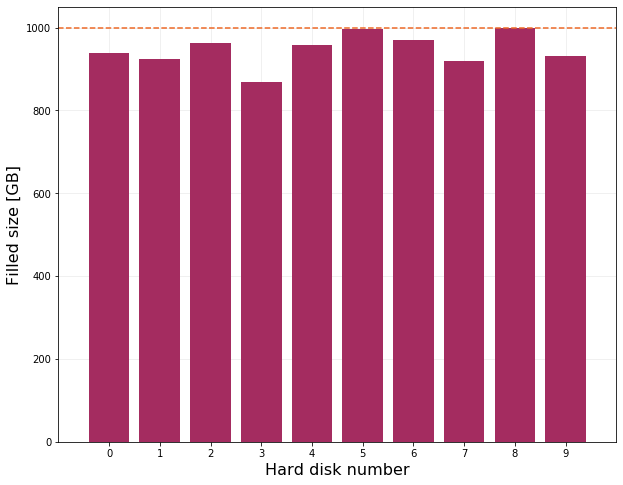

Disks occupation: [ 939.  925.  964.  869.  959.  997.  971.  919. 1000.  931.]
Placed files:     9474
Free space left:  5.26 %


In [20]:
FreeSpace(1)

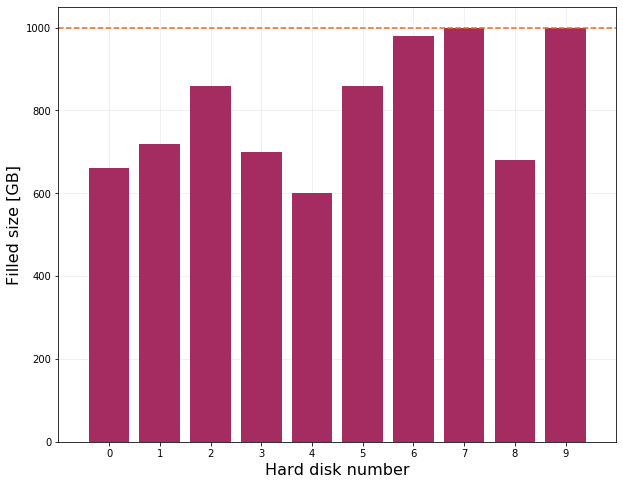

Disks occupation: [ 660.  720.  860.  700.  600.  860.  980. 1000.  680. 1000.]
Placed files:     403
Free space left:  19.4 %


In [21]:
FreeSpace(20)

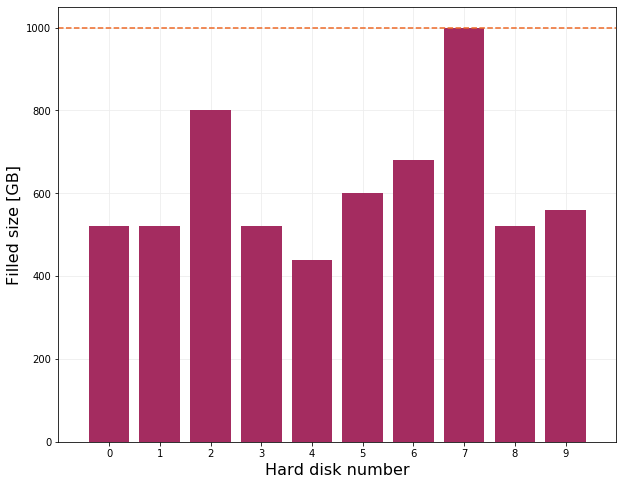

Disks occupation: [ 520.  520.  800.  520.  440.  600.  680. 1000.  520.  560.]
Placed files:     154
Free space left:  38.4 %


In [22]:
FreeSpace(40)

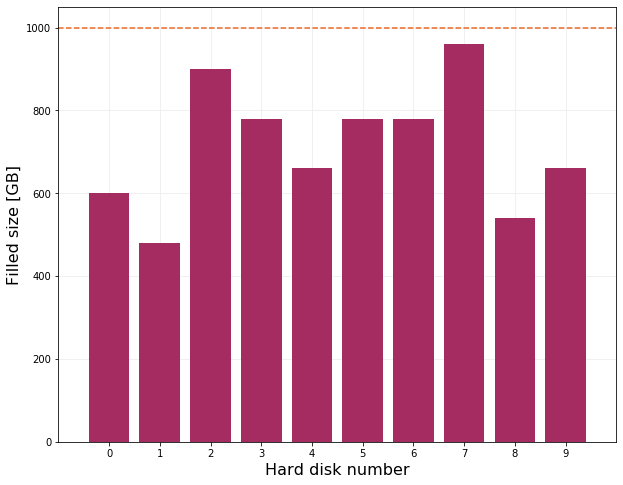

Disks occupation: [600. 480. 900. 780. 660. 780. 780. 960. 540. 660.]
Placed files:     119
Free space left:  28.6 %


In [23]:
FreeSpace(60)

<br>
<br>

### 4.3. - Free space left as a function of file size<a class="anchor" id="MAPD_B_FP.4.3."></a>

We observe that the free space left for 1GB files is less than if we use 10GB or 40GB files. Let us further investigate this trend with the following plot.

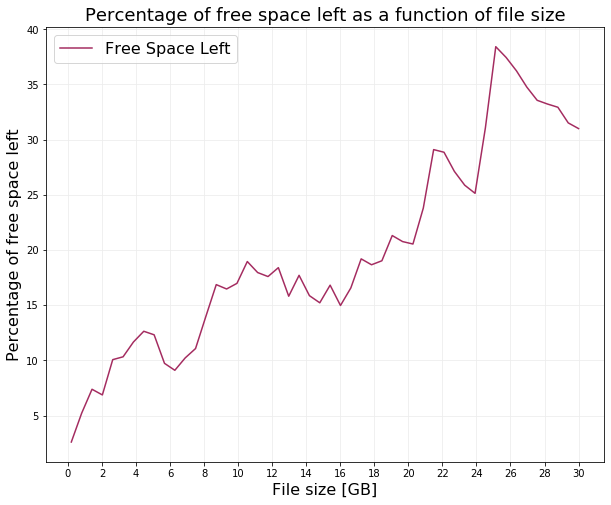

In [24]:
min_size = 0.2
max_size = 30
sizes= np.linspace(min_size, max_size, 50)
y=[]

for size in sizes:
    p,f= FreeSpace(size, False, False, True)
    y.append(f)
    
# Plot the results
fig, ax =  plt.subplots(figsize=(10,8))
ax.plot(sizes, y, color=palette.inferno(10)[4], label='Free Space Left')
plt.xticks(range(int(min_size),int(max_size)+1,2),range(int(min_size),int(max_size)+1,2))
ax.grid(True, which="both", ls="-",color='0.93')
ax.set_axisbelow(True)
ax.set_xlabel('File size [GB]',fontsize=16)
ax.set_ylabel('Percentage of free space left',fontsize=16)
ax.set_title("Percentage of free space left as a function of file size",fontsize=18)
plt.legend(fontsize=16)
plt.show()

As expected, we observe that increasing the file size, the percentage of filled size increases. Hence, it is more convenient to store fixed size blocks of ~4M and not files of GBs.